d:\anaconda3\envs\gyenv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32, 1, 32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\anaconda3\envs\gyenv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([8, 1, 8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


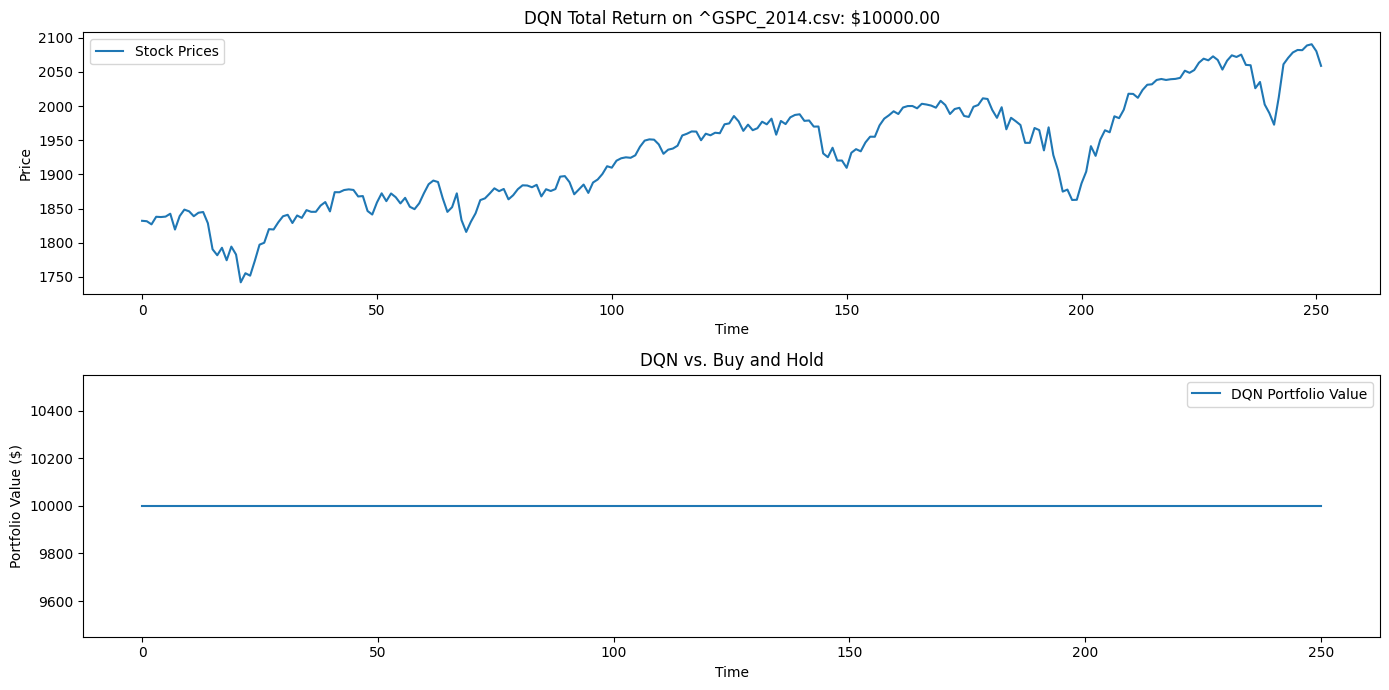

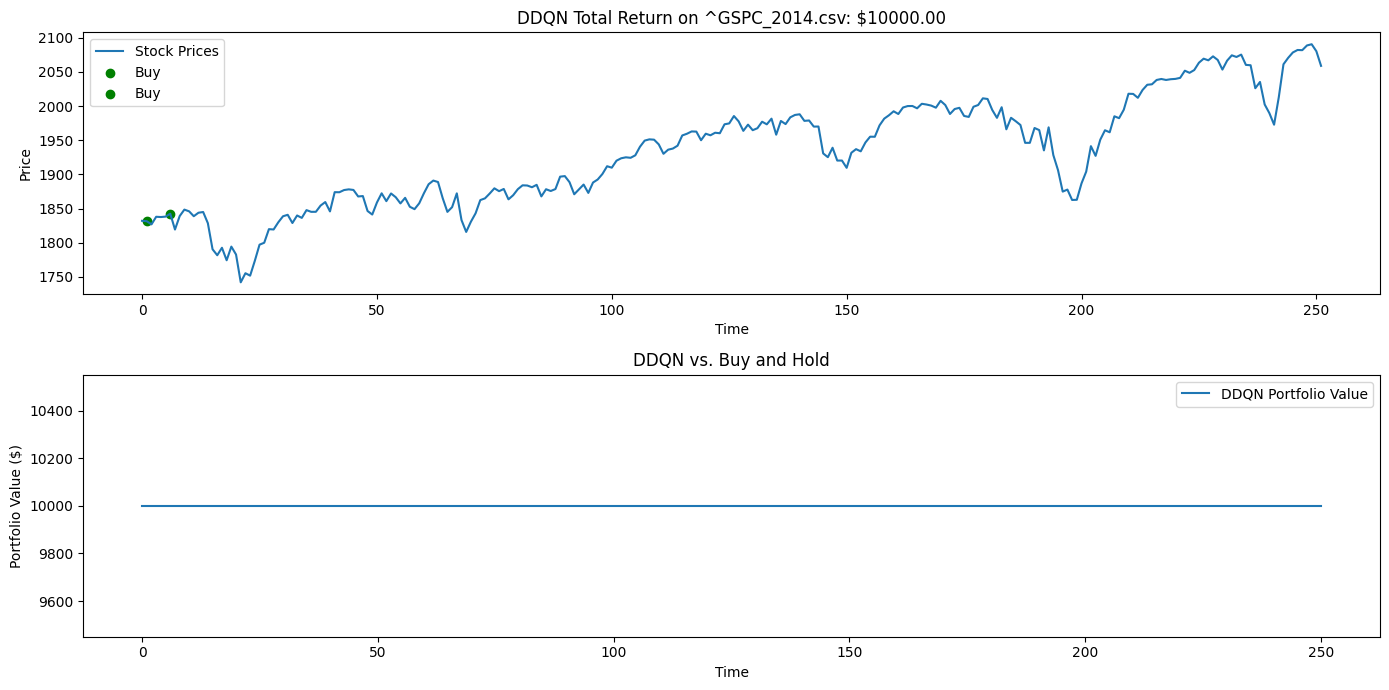

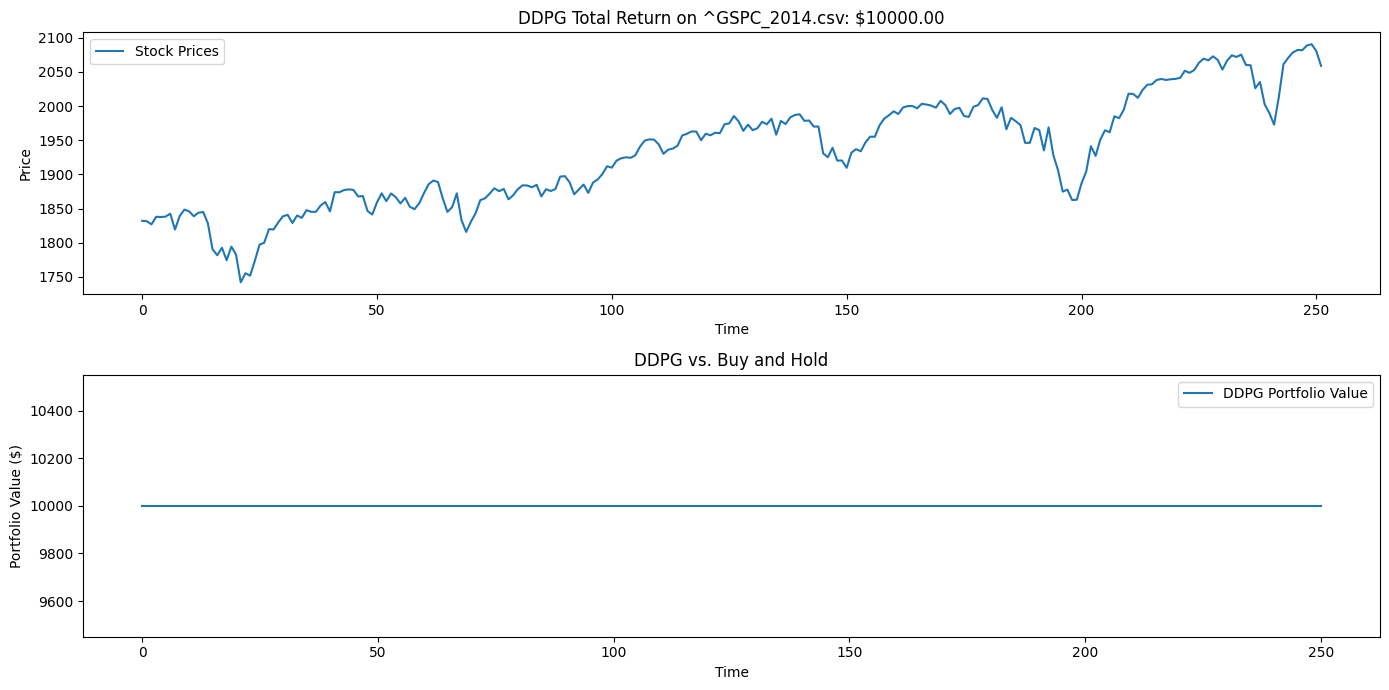

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set file name for data
data_file_name = '^GSPC_2014.csv'  # Specify your file name here

# Create the saved_models directory if it doesn't exist
os.makedirs('saved_models', exist_ok=True)

# Define the environment and portfolio management
class Portfolio:
    def __init__(self, balance):
        self.balance = balance
        self.inventory = []
        self.buy_dates = []
        self.buy_prices = []
        self.sell_dates = []
        self.sell_prices = []
    
    def buy(self, date, price, amount):
        cost = price * amount
        if self.balance >= cost:
            self.balance -= cost
            self.inventory.append((date, price, amount))
            self.buy_dates.append(date)
            self.buy_prices.append(price)
    
    def sell(self, date, price, amount):
        revenue = price * amount
        self.balance += revenue
        self.inventory = [i for i in self.inventory if i[0] != date]  # Simplified for demonstration
        self.sell_dates.append(date)
        self.sell_prices.append(price)

    def evaluate(self, current_price):
        total_value = self.balance
        for _, price, amount in self.inventory:
            total_value += amount * current_price
        return total_value

def generate_combined_state(t, window_size, stock_prices, balance, inventory_len):
    start = max(0, t - window_size)
    state = list(stock_prices[start:t]) + [balance] + [inventory_len]
    state = np.pad(state, (0, max(0, 13 - len(state))), 'constant')  # Ensure state has size 13
    return np.array(state)

def evaluate_portfolio_performance(agent, stock_prices):
    total_value = [agent.evaluate(price) for price in stock_prices]
    return total_value

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class DDQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DDQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class DDPGActor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DDPGActor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x))  # Use tanh to ensure action range is [-1, 1]
        return x

class DDPGCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DDPGCritic, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)
    
    def forward(self, state, action):
        state = state.view(-1, state.size(-1))
        action = action.view(-1, action.size(-1))
        
        # Ensure state and action have compatible sizes for concatenation
        expected_size = self.fc1.in_features
        if state.size(1) + action.size(1) != expected_size:
            raise ValueError(f"Expected state + action size to be {expected_size}, but got {state.size(1) + action.size(1)}")
        
        x = torch.cat([state, action], dim=1)  # Concatenate along dimension 1
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define training functions
def train_dqn(model, optimizer, criterion, dataloader, epochs=100):
    model.train()
    for epoch in range(epochs):
        for state, action, reward, next_state, done in dataloader:
            state, action, reward, next_state, done = \
                state.to(device), action.to(device).long(), reward.to(device), \
                next_state.to(device), done.to(device)

            # Model output (Q-values for each action)
            q_values = model(state)  # Shape: [batch_size, num_actions]
            
            # Ensure action is 2D with shape [batch_size, 1] and dtype int64
            action = action.view(-1, 1).long()  # Reshape to [batch_size, 1] and convert to long
            
            # Gather Q-values for the chosen actions
            q_values = q_values.gather(1, action)  # Shape: [batch_size, 1]

            # Calculate next Q-values
            next_q_values = model(next_state).max(1)[0].detach()
            target_q_values = reward + (1 - done) * 0.99 * next_q_values
            
            # Compute loss and perform optimization
            loss = criterion(q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

def train_ddqn(model, target_model, optimizer, criterion, dataloader, epochs=100):
    model.train()
    target_model.eval()
    for epoch in range(epochs):
        for state, action, reward, next_state, done in dataloader:
            state, action, reward, next_state, done = \
                state.to(device), action.to(device).long(), reward.to(device), \
                next_state.to(device), done.to(device)

            # Model output (Q-values for each action)
            q_values = model(state)  # Shape: [batch_size, num_actions]
            
            # Ensure action is 2D with shape [batch_size, 1] and dtype int64
            action = action.view(-1, 1).long()  # Reshape to [batch_size, 1] and convert to long
            
            # Gather Q-values for the chosen actions
            q_values = q_values.gather(1, action)  # Shape: [batch_size, 1]

            # Calculate next Q-values
            next_action = model(next_state).max(1)[1].unsqueeze(1)
            next_q_values = target_model(next_state).gather(1, next_action).detach()
            target_q_values = reward + (1 - done) * 0.99 * next_q_values
            
            # Compute loss and perform optimization
            loss = criterion(q_values, target_q_values)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

def train_ddpg(actor, critic, actor_optimizer, critic_optimizer, dataloader, epochs=100):
    actor.train()
    critic.train()
    for epoch in range(epochs):
        for state, action, reward, next_state, done in dataloader:
            state, action, reward, next_state, done = \
                state.to(device), action.to(device), reward.to(device), \
                next_state.to(device), done.to(device)

            # Update Critic
            next_action = actor(next_state)
            target_q_values = reward + (1 - done) * 0.99 * critic(next_state, next_action).detach()
            q_values = critic(state, action)
            critic_loss = nn.MSELoss()(q_values, target_q_values)
            critic_optimizer.zero_grad()
            critic_loss.backward()
            critic_optimizer.step()

            # Update Actor
            actor_loss = -critic(state, actor(state)).mean()
            actor_optimizer.zero_grad()
            actor_loss.backward()
            actor_optimizer.step()

def evaluate_with_signals(model, data_file_name):
    df = pd.read_csv(f'data/{data_file_name}')
    stock_prices = df['Close'].values
    window_size = 10  # Assuming a window size of 10 for state generation
    initial_balance = 10000
    agent = Portfolio(initial_balance)
    
    state = generate_combined_state(0, window_size, stock_prices, agent.balance, len(agent.inventory))
    state = torch.FloatTensor(state).unsqueeze(0).to(device)
    
    portfolio_values = []
    buy_signals = []
    sell_signals = []

    model.eval()
    with torch.no_grad():
        for t in range(1, len(stock_prices)):
            actions = model(state).cpu().detach().numpy()
            action = np.argmax(actions[0])
            
            if action == 1:  # Buy
                agent.buy(t, stock_prices[t], amount=10)
                buy_signals.append((t, stock_prices[t]))
            elif action == 2:  # Sell
                if agent.inventory:
                    agent.sell(t, stock_prices[t], amount=10)
                    sell_signals.append((t, stock_prices[t]))
            
            state = generate_combined_state(t, window_size, stock_prices, agent.balance, len(agent.inventory))
            state = torch.FloatTensor(state).unsqueeze(0).to(device)
            
            portfolio_value = agent.evaluate(stock_prices[t])
            portfolio_values.append(portfolio_value)

    return portfolio_values, buy_signals, sell_signals

def plot_with_signals(stock_prices, portfolio_values, buy_signals, sell_signals, model_name, data_file_name):
    plt.figure(figsize=(14, 7))
    
    # Plot stock prices and signals
    plt.subplot(2, 1, 1)
    plt.plot(stock_prices, label='Stock Prices')
    for signal in buy_signals:
        plt.scatter(signal[0], signal[1], color='green', marker='o', label='Buy')
    for signal in sell_signals:
        plt.scatter(signal[0], signal[1], color='red', marker='o', label='Sell')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.title(f'{model_name} Total Return on {data_file_name}: ${portfolio_values[-1]:.2f}')
    
    # Plot portfolio value
    plt.subplot(2, 1, 2)
    plt.plot(portfolio_values, label=f'{model_name} Portfolio Value')
    plt.xlabel('Time')
    plt.ylabel('Portfolio Value ($)')
    plt.legend()
    plt.title(f'{model_name} vs. Buy and Hold')

    plt.tight_layout()
    plt.show()

def load_model(model, path):
    model.load_state_dict(torch.load(path))
    model.eval()

def save_model(model, path):
    torch.save(model.state_dict(), path)

# Main script
if __name__ == '__main__':
    stock_prices = pd.read_csv(f'data/{data_file_name}')['Close'].values
    
    # Generate training data (dummy example, should be replaced with actual data preprocessing)
    states = np.random.randn(1000, 13)
    actions = np.random.randint(0, 3, size=(1000, 1))
    rewards = np.random.randn(1000, 1)
    next_states = np.random.randn(1000, 13)
    dones = np.random.randint(0, 2, size=(1000, 1))
    
    dataset = TensorDataset(torch.FloatTensor(states), torch.FloatTensor(actions), torch.FloatTensor(rewards),
                            torch.FloatTensor(next_states), torch.FloatTensor(dones))
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
    
    # DQN model
    dqn_model = DQN(state_dim=13, action_dim=3).to(device)
    optimizer = optim.Adam(dqn_model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    train_dqn(dqn_model, optimizer, criterion, dataloader, epochs=10)
    save_model(dqn_model, 'saved_models/dqn_model.pth')
    
    dqn_portfolio, dqn_buy_signals, dqn_sell_signals = evaluate_with_signals(dqn_model, data_file_name)
    plot_with_signals(stock_prices, dqn_portfolio, dqn_buy_signals, dqn_sell_signals, 'DQN', data_file_name)

    # DDQN model
    ddqn_model = DDQN(state_dim=13, action_dim=3).to(device)
    ddqn_target_model = DDQN(state_dim=13, action_dim=3).to(device)
    optimizer = optim.Adam(ddqn_model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    train_ddqn(ddqn_model, ddqn_target_model, optimizer, criterion, dataloader, epochs=10)
    save_model(ddqn_model, 'saved_models/ddqn_model.pth')
    save_model(ddqn_target_model, 'saved_models/ddqn_target_model.pth')
    
    ddqn_portfolio, ddqn_buy_signals, ddqn_sell_signals = evaluate_with_signals(ddqn_model, data_file_name)
    plot_with_signals(stock_prices, ddqn_portfolio, ddqn_buy_signals, ddqn_sell_signals, 'DDQN', data_file_name)

    # DDPG model
    ddpg_actor = DDPGActor(state_dim=13, action_dim=1).to(device)
    ddpg_critic = DDPGCritic(state_dim=13, action_dim=1).to(device)
    actor_optimizer = optim.Adam(ddpg_actor.parameters(), lr=0.001)
    critic_optimizer = optim.Adam(ddpg_critic.parameters(), lr=0.001)
    train_ddpg(ddpg_actor, ddpg_critic, actor_optimizer, critic_optimizer, dataloader, epochs=10)
    save_model(ddpg_actor, 'saved_models/ddpg_actor.pth')
    save_model(ddpg_critic, 'saved_models/ddpg_critic.pth')
    
    ddpg_portfolio, ddpg_buy_signals, ddpg_sell_signals = evaluate_with_signals(ddpg_actor, data_file_name)  # Assuming we use the actor for evaluation
    plot_with_signals(stock_prices, ddpg_portfolio, ddpg_buy_signals, ddpg_sell_signals, 'DDPG', data_file_name)
